1. ARMA-GARCH

Combines:
- $\operatorname{ARMA}(p, q)$ : for the mean of a time series
- $\operatorname{GARCH}(p, q)$ : for the conditional variance (volatility)

ARMA(p,q) (Mean Process)

$$
y_t=\mu+\sum_{i=1}^p \phi_i y_{t-i}+\sum_{j=1}^q \theta_j \epsilon_{t-j}+\epsilon_t
$$


GARCH(1,1) (Variance Process)

$$
\begin{gathered}
\epsilon_t=\sigma_t z_t, \quad z_t \sim \mathcal{N}(0,1) \\
\sigma_t^2=\omega+\alpha \epsilon_{t-1}^2+\beta \sigma_{t-1}^2
\end{gathered}
$$


Used when volatility clusters-large changes follow large ones.

2. ARMAX-GARCH

ARMAX $=$ ARMA + exogenous variables (external predictors)
ARMAX(p,q,X) (Mean with External Predictors)

$$
y_t=\mu+\sum_{i=1}^p \phi_i y_{t-i}+\sum_{j=1}^q \theta_j \epsilon_{t-j}+\gamma^{\top} X_t+\epsilon_t
$$

- $X_t$ : vector of external regressors
- Still modeled with GARCH for variance

Used when you suspect other variables influence both the mean and volatility (e.g., market indicators).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tqdm import *
import os
from datasets import load_dataset
from utils_1 import read_txn_data, preprocess_txn_data, compute_lob_features, create_lob_dataset, merge_txn_and_lob

In [3]:
trx_df = read_txn_data(use_load=False)
lob_df = create_lob_dataset(use_load=False)
trx_df = preprocess_txn_data(trx_df, freq='1min', fill_missing_ts=False)
df = merge_txn_and_lob(trx_df, lob_df)

trx Data loaded successfully.
preprocessed lob Data loaded successfully.


In [4]:
print(trx_df['deseasoned_total_volume'].sort_values(ascending=False).head(20))

75318     65.318460
39984     62.941083
75378     59.036116
152680    55.210408
41506     52.427006
59114     51.774986
140160    51.231947
94372     50.588350
79199     49.157242
75774     48.751919
104975    47.848879
40022     46.454498
59219     43.888540
156180    43.834805
40023     43.809122
79200     43.453253
75317     43.333464
31249     43.296509
100558    43.027204
75332     42.986508
Name: deseasoned_total_volume, dtype: float64


Axes(0.125,0.11;0.775x0.77)


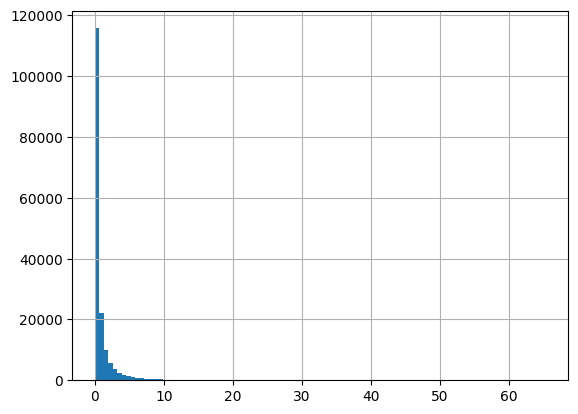

In [5]:
print(trx_df['deseasoned_total_volume'].hist(bins=100))

In [6]:
# Re-import required modules after kernel reset
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Simulate deseasoned volume again
np.random.seed(42)

trx_df['log_volume'] = np.log(trx_df['deseasoned_total_volume'])

# Split into train/test (90/10)
split_idx = int(0.9 * len(trx_df))
train = trx_df.iloc[:split_idx]
test = trx_df.iloc[split_idx:]

In [7]:
lob_df

,index,datetime,ask_volume,bid_volume,ask_slope_1,ask_slope_5,ask_slope_10,bid_slope_1,bid_slope_5,bid_slope_10,spread,lob_volume_imbalance,slope_imbalance_1,slope_imbalance_5,slope_imbalance_10
0,8640,2018-06-04 22:00:02+00:00,2695.804973,586356.113693,1761.630667,2695.804973,2695.804973,3.972121,53.502450,160.246934,6.19,583660.308720,1757.658546,2642.302523,2535.558040
1,8641,2018-06-04 22:00:34+00:00,2696.561478,586351.269401,1762.459233,2696.561478,2696.561478,3.339124,52.739443,155.402642,6.19,583654.707923,1759.120109,2643.822035,2541.158836
2,8642,2018-06-04 22:01:01+00:00,2699.165417,586350.938081,1765.312385,2699.165417,2699.165417,4.017044,52.408273,155.071322,4.97,583651.772664,1761.295341,2646.757144,2544.094095
3,8643,2018-06-04 22:01:33+00:00,2656.934508,586307.355517,1724.074201,2656.934508,2656.934508,4.090007,47.761226,159.376480,4.96,583650.421009,1719.984195,2609.173283,2497.558029
4,8644,2018-06-04 22:02:02+00:00,2657.946212,586317.596946,1723.843180,2657.946212,2657.946212,3.831055,46.578294,158.194750,4.90,583659.650734,1720.012125,2611.367918,2499.751462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311901,306141,2018-09-30 21:57:34+00:00,2954.913408,502228.305974,1687.117833,2784.265802,2784.285802,90.811525,136.921381,224.583439,1.58,499273.392566,1596.306309,2647.344421,2559.702363
311902,306142,2018-09-30 21:58:01+00:00,2926.069752,502208.483731,1665.941703,2755.329981,2755.349981,35.426281,134.735138,221.985996,1.59,499282.413979,1630.515422,2620.594843,2533.363985
311903,306143,2018-09-30 21:58:34+00:00,2927.899054,502203.145173,1667.771006,2757.159283,2757.179283,24.942923,138.264580,225.515438,0.76,499275.246118,1642.828082,2618.894703,2531.663845
311904,306144,2018-09-30 21:59:01+00:00,2959.560045,502203.053143,1700.221163,2789.609440,2789.629440,88.619583,139.576440,225.423408,0.75,499243.493098,1611.601580,2650.033001,2564.206032


In [8]:
trx_df.columns

Index(['datetime', 'buy_volume', 'sell_volume', 'buy_txn', 'sell_txn',
       'volume_imbalance', 'txn_imbalance', 'total_volume', 'mean_volume',
       'deseasoned_total_volume', 'log_deseasoned_total_volume', 'log_volume'],
      dtype='object')

In [9]:

# Assume trx_df with 'log_volume' already defined
series = pd.DataFrame(trx_df['log_deseasoned_total_volume'])
split = int(0.9 * len(series))
train, test = series.iloc[:split], series.iloc[split:]

In [10]:
series

,log_deseasoned_total_volume
0,0.615156
1,-3.911464
2,-5.172914
3,-4.497401
4,-1.467707
...,...
168781,-1.414932
168782,-3.458380
168783,-1.644332
168784,-2.026329


Original-scale metrics:
 R²      = -0.001
 RMSE    = 1.980
 MAE     = 0.878
 MAPE (%) = 10051.1%


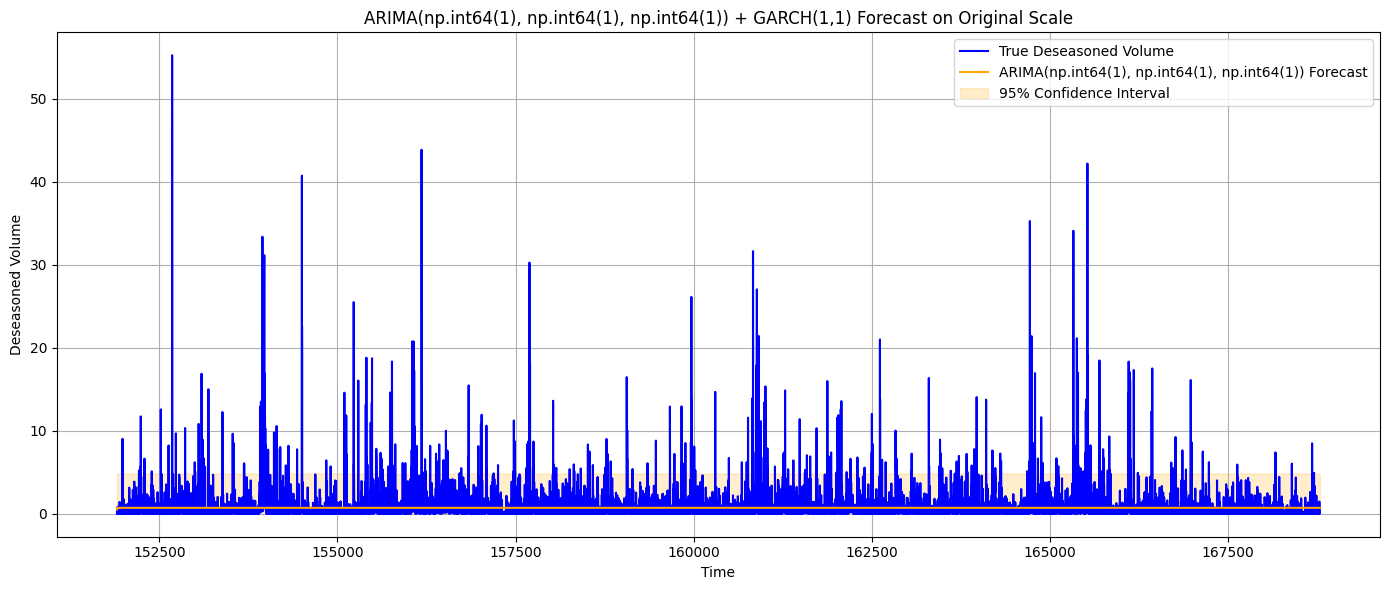

In [ ]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Split into train/test (90/10)
split_idx = int(0.9 * len(trx_df))
train = trx_df.iloc[:split_idx]
test = trx_df.iloc[split_idx:]

# Use auto_arima for parameter selection
auto_model = auto_arima(
    train['log_deseasoned_total_volume'],
    start_p=0, start_q=0, start_d=0,
    max_p=1, max_q=1, max_d=1,
    seasonal=False, stepwise=True, trace=True,
    error_action='ignore', suppress_warnings=True
)
best_order = auto_model.order
print(f"Best ARIMA order: {best_order}, AIC: {auto_model.aic()}")

# Fit ARIMA with best order
model = ARIMA(train['log_deseasoned_total_volume'], order=best_order).fit()
forecast = model.forecast(steps=len(test))
test['arma_pred'] = forecast

# Fit GARCH(1,1) on ARIMA residuals (subsample for speed)
residuals = model.resid
subsample_idx = np.random.choice(len(residuals), size=min(10000, len(residuals)), replace=False)
garch = arch_model(residuals[subsample_idx], vol='Garch', p=1, q=1, dist='Normal')
garch_fit = garch.fit(disp='off')

# Forecast volatility
garch_forecast = garch_fit.forecast(horizon=len(test))
vol_forecast = np.sqrt(garch_forecast.variance.values[-1, :])

# Confidence intervals
test['arma_pred_lower'] = test['arma_pred'] - 1.96 * vol_forecast
test['arma_pred_upper'] = test['arma_pred'] + 1.96 * vol_forecast

# Calculate metrics
r2_arma = r2_score(test['log_deseasoned_total_volume'], test['arma_pred'])
rmse_arma = np.sqrt(mean_squared_error(test['log_deseasoned_total_volume'], test['arma_pred']))
mae_arma = mean_absolute_error(test['log_deseasoned_total_volume'], test['arma_pred'])
mape_arma = np.mean(np.abs((test['log_deseasoned_total_volume'] - test['arma_pred']) / test['log_deseasoned_total_volume'])) * 100

# Plot results
plt.figure(figsize=(14, 8))
plt.plot(test.index, test['log_deseasoned_total_volume'], label='True Log Volume', color='blue')
plt.plot(test.index, test['arma_pred'], label='ARIMA Prediction', color='orange')
plt.fill_between(test.index, test['arma_pred_lower'], test['arma_pred_upper'], 
                 color='orange', alpha=0.2, label='95% Confidence Interval')
plt.title(f'ARIMA{best_order} + GARCH(1,1) Forecasting Log Volume')
plt.xlabel('Time')
plt.ylabel('Log Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Residual diagnostics
residuals_test = test['log_deseasoned_total_volume'] - test['arma_pred']
plt.figure(figsize=(14, 4))
plt.plot(test.index, residuals_test, label='Residuals')
plt.title('Residuals of ARIMA Forecast')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display metrics
metrics = {
    'ARIMA Order': best_order,
    'ARMA R²': r2_arma,
    'ARMA RMSE': rmse_arma,
    'ARMA MAE': mae_arma,
    'ARMA MAPE (%)': mape_arma
}
print(metrics)

Original-scale metrics:
 R²      = -0.001
 RMSE    = 1.980
 MAE     = 0.878
 MAPE (%) = 10051.1%


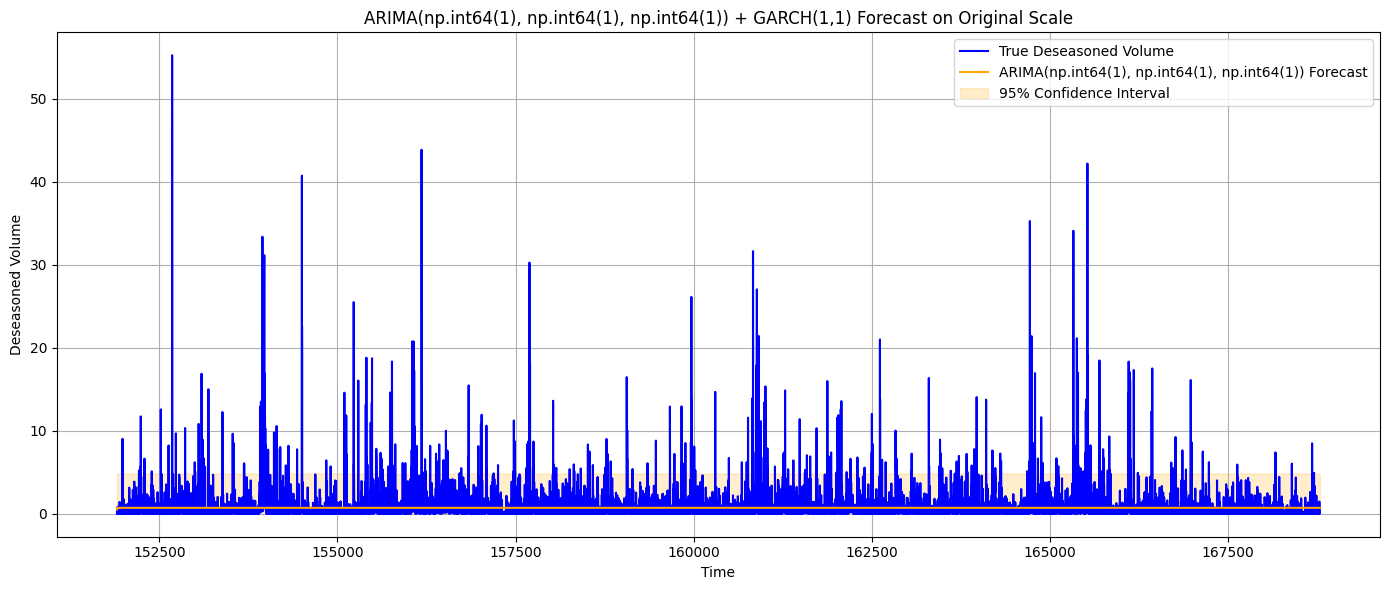

In [16]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Ensure data is valid
if (test['deseasoned_total_volume'] <= 0).any():
    raise ValueError("deseasoned_total_volume contains non-positive values, invalid for log transformation.")

# 1) Back-transform ARIMA forecasts with bias correction
# Estimate variance from GARCH or residuals for bias correction
garch_vol = np.sqrt(garch_forecast.variance.values[-1, :])  # From previous GARCH model
test['vol_pred'] = np.exp(test['arma_pred'] + 0.5 * garch_vol**2)  # Bias correction

# 2) Back-transform CI bounds (approximate, as exact CIs are complex)
# Note: This is a simplification; exact CIs require log-normal distribution assumptions
test['vol_pred_lower'] = np.exp(test['arma_pred_lower'])
test['vol_pred_upper'] = np.exp(test['arma_pred_upper'])

# 3) Compute metrics on the original volume
true_vol = test['deseasoned_total_volume']
pred_vol = test['vol_pred']

# Avoid division by zero in MAPE
true_vol_safe = true_vol.replace(0, np.finfo(float).eps)  # Replace 0 with small value
r2_vol = r2_score(true_vol, pred_vol)
rmse_vol = np.sqrt(mean_squared_error(true_vol, pred_vol))
mae_vol = mean_absolute_error(true_vol, pred_vol)
mape_vol = np.mean(np.abs((true_vol - pred_vol) / true_vol_safe)) * 100

print("Original-scale metrics:")
print(f" R²      = {r2_vol:.3f}")
print(f" RMSE    = {rmse_vol:.3f}")
print(f" MAE     = {mae_vol:.3f}")
print(f" MAPE (%) = {mape_vol:.1f}%")

# 4) Plot on the original scale
plt.figure(figsize=(14, 6))
plt.plot(test.index, true_vol, label='True Deseasoned Volume', color='blue')
plt.plot(test.index, pred_vol, label=f'ARIMA{best_order} Forecast', color='orange')
plt.fill_between(test.index, test['vol_pred_lower'], test['vol_pred_upper'], 
                 color='orange', alpha=0.2, label='95% Confidence Interval')
plt.title(f'ARIMA{best_order} + GARCH(1,1) Forecast on Original Scale')
plt.xlabel('Time')
plt.ylabel('Deseasoned Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

# --- 1) Prepare data and split 90/10 ---
# Assuming trx_df is your DataFrame and has a datetime index or is already sorted
series = trx_df['deseasoned_total_volume'].dropna().values

n = len(series)
train_size = int(n * 0.9)

y_train = series[:train_size]
y_test  = series[train_size:]

# --- 2) Build mean predictor on training set ---
mean_pred = np.mean(y_train)
y_pred_mean = np.full_like(y_test, fill_value=mean_pred)

# --- 3) Compute metrics ---
mse  = mean_squared_error(y_test, y_pred_mean)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred_mean)
mape = np.mean(np.abs((y_test - y_pred_mean) / (y_test + 1e-8))) * 100
r2   = r2_score(y_test, y_pred_mean)
medae = np.median(np.abs(y_test - y_pred_mean))
mase  = mae / np.mean(np.abs(y_train[1:] - y_train[:-1]))

metrics = {
    'MSE'                     : mse,
    'RMSE'                    : rmse,
    'MAE'                     : mae,
    'MAPE (%)'                : mape,
    'R²'                      : r2,
    'Median Absolute Error'   : medae,
    'Mean Absolute Scaled Error (MASE)': mase
}

# --- 4) Display results ---
print("Baseline (mean‐predictor) Performance Metrics")
print("─" * 45)
for name, val in metrics.items():
    print(f"{name:30}: {val:.4f}")


Baseline (mean‐predictor) Performance Metrics
─────────────────────────────────────────────
MSE                           : 3.9772
RMSE                          : 1.9943
MAE                           : 1.0502
MAPE (%)                      : 14342.5774
R²                            : -0.0152
Median Absolute Error         : 0.9107
Mean Absolute Scaled Error (MASE): 0.9787
